### Libraries

In [1]:
import time
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from IPython.display import Image

import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz

from imblearn.over_sampling import SMOTE, ADASYN

import xgboost as xgb
from plot_learning import *
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

import skfuzzy as fuzz
from skfuzzy import control as ctrl

warnings.filterwarnings('ignore')

c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read 

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

X_train = pd.read_csv("X_train.csv", sep = ";")
X_test = pd.read_csv("X_test.csv", sep = ";")

y_train = pd.read_csv("y_train.csv", sep = ";")
y_test = pd.read_csv("y_test.csv", sep = ";")

X_train.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO
0,63,34,27,10.3,8.3,48.7,11.5,1.19,0.46,0.52
1,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40
2,66,34,29,11.4,5.8,49.4,11.1,0.87,0.25,0.23
3,101,77,46,10.9,13.3,52.2,17.3,1.48,0.27,1.07
4,83,46,19,8.5,10.3,49.3,14.9,1.05,0.39,0.39


In [3]:
## removendo variáveis 
X_train = X_train.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

X_test = X_test.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

In [4]:
X_train.columns

Index(['RFV', 'H2RFV', 'CONICITY', 'PLY', 'LFV', 'RRO', 'CAPSPLICE'], dtype='object')

In [5]:
y_train.GR.unique()

array(['B', 'A', 'C'], dtype=object)

In [6]:
y_train.GR.value_counts()

GR
B    35
A    34
C    11
Name: count, dtype: int64

## Dataprep

In [7]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc

In [29]:
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [30]:
print(Counter(y_train_enc).keys())
print(Counter(y_train_enc).values())

dict_keys([1, 0, 2])
dict_values([35, 34, 11])


In [31]:
print(Counter(y_test_enc).keys())
print(Counter(y_test_enc).values())

dict_keys([1, 0, 2])
dict_values([11, 12, 4])


In [32]:
file_std = "./models/std.pickle"
# file_smote = "./models/smote.pickle"

std = joblib.load(file_std)
# smote= joblib.load(file_smote)

In [33]:
file_std_smote = "./models/std_smote.pickle"
file_smote = "./models/smote.pickle"

std_smote = joblib.load(file_std_smote)
smote= joblib.load(file_smote)

In [34]:
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [35]:
X_train_std_smote = std_smote.transform(X_train)
X_test_std_smote = std_smote.transform(X_test)

In [36]:
X_resampled, y_resampled = smote.fit_resample(X_train_std_smote, y_train_enc)

In [37]:
X_resampled.shape

(105, 7)

In [38]:
y_resampled.shape

(105,)

## Predict

In [39]:
def fit_and_print(model, X_test, y_test):
    y_pred = model.predict(X_test)
    # print("Confusion Matrix: \n", confusion_matrix(y_test_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    index =["A", "B", "C"]
    columns =["A", "B", "C"]
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred))  

### Models

In [40]:
filename_1 = './models/RF_best_bayes.sav'
filename_2 = './models/SVM_best_bayes.sav'
filename_3 = './models/LR_best_bayes.sav'
filename_4 = './models/KNN_best_bayes.sav'
filename_5 = './models/GBM_best_bayes.sav'


RF_best = joblib.load(filename_1)
SVM_best = joblib.load(filename_2)
LR_best = joblib.load(filename_3)
KNN_best = joblib.load(filename_4)
GBM_best = joblib.load(filename_5)

### Voting Classifier

In [41]:
model_RF = pd.Series(RF_best.predict(X_test_std), name="RF")
model_LR = pd.Series(LR_best.predict(X_test_std), name= "LR")
model_SVM = pd.Series(SVM_best.predict(X_test_std), name="SVM")
model_GBM = pd.Series(GBM_best.predict(X_test_std), name="GBM")
model_KNN = pd.Series(KNN_best.predict(X_test_std), name="KNN")

In [42]:
import scipy.stats as stats

tau, p_value = stats.kendalltau(model_RF, model_GBM)
p_value

3.455812737535815e-05

In [43]:
def fit_and_print_v2(model, X_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_enc, y_pred)
    index =["A", "B", "C"]
    columns =["A", "B", "C"]
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test_enc, y_pred))  


Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.77      0.91      0.83        11
           2       1.00      0.50      0.67         4

    accuracy                           0.85        27
   macro avg       0.90      0.78      0.81        27
weighted avg       0.87      0.85      0.85        27



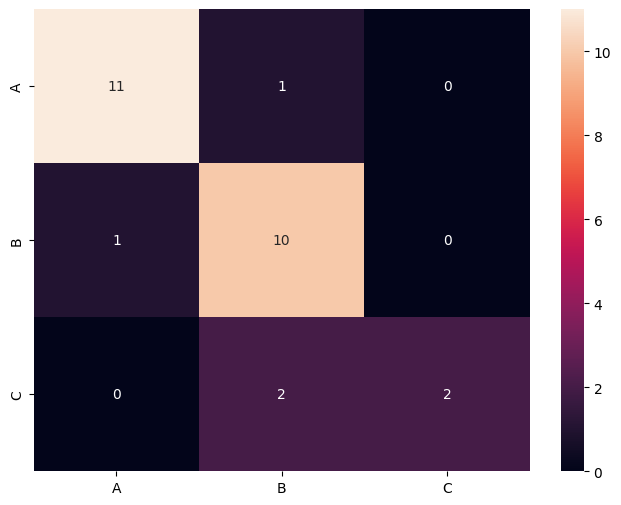

In [44]:
fit_and_print_v2(RF_best, X_test_std)

## Ensemble 

In [45]:
# Definindo os modelos
models = [
    # ('rf', RF_best),
    # ('svm', SVM_best),
    ('lr', LR_best),
    # ('knn', KNN_best),
    ('gbm', GBM_best)

]

In [46]:
from sklearn.ensemble import StackingClassifier

In [47]:
# Criando o ensemble
ensemble_model = VotingClassifier(estimators=models, voting='soft')

ensemble_model.fit(X_train_std, y_train_enc)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=3.8553146696590823,
                                                 class_weight='balanced',
                                                 multi_class='multinomial',
                                                 random_state=25, solver='saga',
                                                 tol=1e-05)),
                             ('gbm',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_features='sqrt',
                                                         min_samples_leaf=2,
                                                         min_samples_split=9,
                                                         n_estimators=15,
                                                         random_state=32))],
                 voting='soft')

In [48]:
# Obter previsões probabilísticas do ensemble
ensemble_proba_train = ensemble_model.predict(X_train_std)
print("Classification Report: \n", classification_report(y_train_enc, ensemble_proba_train))  

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96        34
           1       0.97      0.94      0.96        35
           2       1.00      1.00      1.00        11

    accuracy                           0.96        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.96      0.96      0.96        80



Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.77      0.91      0.83        11
           2       0.67      0.50      0.57         4

    accuracy                           0.85        27
   macro avg       0.81      0.78      0.79        27
weighted avg       0.86      0.85      0.85        27



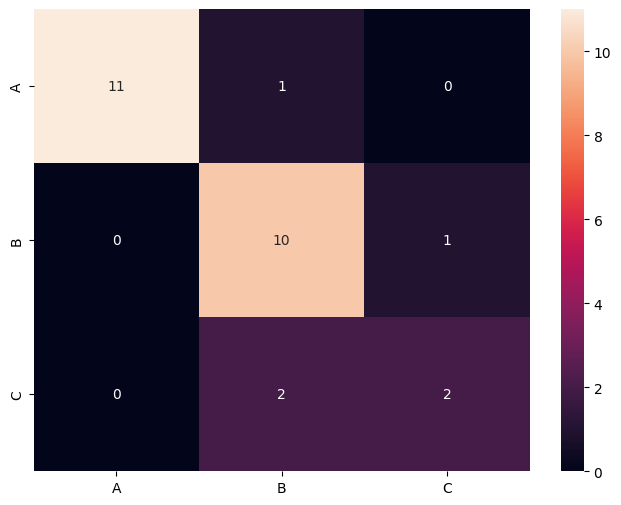

In [49]:
# Obter previsões probabilísticas do ensemble
ensemble_proba = ensemble_model.predict_proba(X_test_std)
fit_and_print_v2(ensemble_model, X_test_std)

In [50]:
data_train=pd.DataFrame()
data_train['y'] = y_train.GR
# data_train["prob_rf"] = RF_best.predict_proba(X_train_std)[:,0]
data_train["prob_lr"] = LR_best.predict_proba(X_train_std)[:,0]
data_train["prob_gbm"] = GBM_best.predict_proba(X_train_std)[:,0]

print("A", data_train[data_train['y']=='A'][['prob_lr', 'prob_gbm']].mean(axis=1).describe())
print("B", data_train[data_train['y']=='B'][['prob_lr', 'prob_gbm']].mean(axis=1).describe())
print("C", data_train[data_train['y']=='C'][['prob_lr', 'prob_gbm']].mean(axis=1).describe())

A count    34.000000
mean      0.770109
std       0.110673
min       0.432746
25%       0.720567
50%       0.815615
75%       0.848038
max       0.868422
dtype: float64
B count    35.000000
mean      0.194422
std       0.110641
min       0.094715
25%       0.110013
50%       0.148540
75%       0.252532
max       0.524209
dtype: float64
C count    11.000000
mean      0.102617
std       0.025225
min       0.080442
25%       0.083847
50%       0.096491
75%       0.110722
max       0.150551
dtype: float64


In [51]:
high = [0.99, 0.004]
medium = [0.28, 0.08]
low = [0.21, 0.04]

In [52]:
data_train=pd.DataFrame()
data_train['y'] = y_train.GR
data_train["prob_rf"] = RF_best.predict_proba(X_train_std)[:,1]
data_train["prob_svm"] = SVM_best.predict_proba(X_train_std)[:,1]
data_train["prob_gbm"] = GBM_best.predict_proba(X_train_std)[:,1]

print("A", data_train[data_train['y']=='A'][['prob_rf', 'prob_svm', 'prob_gbm']].mean(axis=1).describe())
print("B", data_train[data_train['y']=='B'][['prob_rf', 'prob_svm', 'prob_gbm']].mean(axis=1).describe())
print("C", data_train[data_train['y']=='C'][['prob_rf', 'prob_svm', 'prob_gbm']].mean(axis=1).describe())

A count    34.000000
mean      0.152510
std       0.082415
min       0.064760
25%       0.089260
50%       0.130461
75%       0.217064
max       0.347984
dtype: float64
B count    35.000000
mean      0.758517
std       0.058402
min       0.637882
25%       0.720227
50%       0.745931
75%       0.799901
max       0.849561
dtype: float64
C count    11.000000
mean      0.254139
std       0.071273
min       0.148003
25%       0.213841
50%       0.250418
75%       0.306161
max       0.361938
dtype: float64


In [53]:
high = [0.89, 0.03]
medium = [0.35, 0.10]
low = [0.30, 0.13]

In [54]:
data_train=pd.DataFrame()
data_train['y'] = y_train.GR
data_train["prob_rf"] = RF_best.predict_proba(X_train_std)[:,2]
data_train["prob_svm"] = SVM_best.predict_proba(X_train_std)[:,2]
data_train["prob_gbm"] = GBM_best.predict_proba(X_train_std)[:,2]


print("A", data_train[data_train['y']=='A'][['prob_rf', 'prob_svm', 'prob_gbm']].mean(axis=1).describe())
print("B", data_train[data_train['y']=='B'][['prob_rf', 'prob_svm', 'prob_gbm']].mean(axis=1).describe())
print("C", data_train[data_train['y']=='C'][['prob_rf', 'prob_svm', 'prob_gbm']].mean(axis=1).describe())

A count    34.000000
mean      0.033503
std       0.010359
min       0.024429
25%       0.026079
50%       0.033540
75%       0.035022
max       0.071459
dtype: float64
B count    35.000000
mean      0.094210
std       0.025502
min       0.056992
25%       0.078279
50%       0.088315
75%       0.103888
max       0.172748
dtype: float64
C count    11.000000
mean      0.651933
std       0.094795
min       0.510267
25%       0.592269
50%       0.670242
75%       0.705110
max       0.785664
dtype: float64


In [55]:
high = [0.82, 0.07]
medium = [0.12, 0.05]
low = [0.07, 0.01]


In [56]:
########## A ############
high = [0.99, 0.004]
medium = [0.28, 0.08]
low = [0.21, 0.04]
########## B ############
high = [0.89, 0.03]
medium = [0.35, 0.10]
low = [0.30, 0.13]
########## C ############
high = [0.82, 0.07]
medium = [0.12, 0.05]
low = [0.07, 0.01]


### Estimation of mean and standard deviation

In [57]:
def classify_by_rule(data, class_column, id, prob_columns):

    results = {}
    for class_label in data[class_column].unique():
        class_data = data[data[class_column] == class_label]
        mean_probs = class_data[prob_columns].mean(axis=1)
        mean_value = mean_probs.mean()
        std_value = mean_probs.std()

        results[class_label] = {"class": id, "mean": mean_value, "std": std_value}
    
    return results


def prob_class(data_train, train_set, id_class):

    prob_columns = []
    for i, model_probs in enumerate(train_set):
        column_name = f"prob_model_{i+1}"
        data_train[column_name] = model_probs[:, id_class]
        prob_columns.append(column_name)
        return prob_columns


def return_means_std(data_train, train_set):

    classifications = []

    for id_class in range(0, 3):

        prob_columns = prob_class(data_train, train_set, id_class)
        classification = classify_by_rule(data_train, class_column="y", id = id_class, prob_columns=prob_columns)
        classifications.append(classification)

    class_1_high_mean = classifications[0]['A']['mean']
    class_1_medium_mean = classifications[0]['B']['mean']
    class_1_low_mean = classifications[0]['C']['mean']

    class_1_high_std = classifications[0]['A']['std']
    class_1_medium_std = classifications[0]['B']['std']
    class_1_low_std = classifications[0]['C']['std']


    class_2_high_mean = classifications[1]['B']['mean']
    class_2_medium_mean = classifications[1]['C']['mean']
    class_2_low_mean = classifications[1]['A']['mean']

    class_2_high_std = classifications[1]['B']['std']
    class_2_medium_std = classifications[1]['C']['std']
    class_2_low_std = classifications[1]['A']['std']


    class_3_high_mean = classifications[2]['C']['mean']
    class_3_medium_mean = classifications[2]['B']['mean']
    class_3_low_mean = classifications[2]['A']['mean']

    class_3_high_std = classifications[2]['C']['std']
    class_3_medium_std = classifications[2]['B']['std']
    class_3_low_std = classifications[2]['A']['std']

    mean_values  = [[class_1_high_mean, class_1_medium_mean, class_1_low_mean], [class_2_high_mean, class_2_medium_mean, class_2_low_mean], [class_3_high_mean, class_3_medium_mean, class_3_low_mean]]

    std_values  = [[class_1_high_std, class_1_medium_std, class_1_low_std], [class_2_high_std, class_2_medium_std, class_2_low_std], [class_3_high_std, class_3_medium_std, class_3_low_std]]
    
    return mean_values, std_values

## Sistema Fuzzy

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

class FuzzyClassifier:
    def __init__(self, mean_values, std_values):
        self.prob_classe1 = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'Probability for category A')
        self.prob_classe2 = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'Probability for category B')
        self.prob_classe3 = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'Probability for category C')
        self.classe_final = ctrl.Consequent(np.arange(1, 4, 1), 'Final classification')

        m_c1_high = mean_values[0][0]
        m_c1_medium = mean_values[0][1]
        m_c1_low = mean_values[0][2]

        m_c2_high = mean_values[1][0]
        m_c2_medium = mean_values[1][1]
        m_c2_low = mean_values[1][2]

        m_c3_high = mean_values[2][0]
        m_c3_medium = mean_values[2][1]
        m_c3_low = mean_values[2][2]

        s_c1_high = std_values[0][0]
        s_c1_medium = std_values[0][1]
        s_c1_low = std_values[0][2]

        s_c2_high = std_values[1][0]
        s_c2_medium = std_values[1][1]
        s_c2_low = std_values[1][2]

        s_c3_high = std_values[2][0]
        s_c3_medium = std_values[2][1]
        s_c3_low = std_values[2][2]


        self._define_membership_functions(m_c1_high, m_c1_medium, m_c1_low, m_c2_high, m_c2_medium, m_c2_low, m_c3_high, 
                                          m_c3_medium, m_c3_low, s_c1_high, s_c1_medium, s_c1_low, s_c2_high, s_c2_medium,
                                          s_c2_low, s_c3_high, s_c3_medium, s_c3_low)

        self.classe_final['Category A'] = fuzz.trimf(self.classe_final.universe, [0.5, 1, 1.5])
        self.classe_final['Category B'] = fuzz.trimf(self.classe_final.universe, [1.5, 2, 2.5])
        self.classe_final['Category C'] = fuzz.trimf(self.classe_final.universe, [2.5, 3, 3.5])

        self.classe_final.defuzzify_method = 'centroid'#'mom'

        self.rules = self._define_rules()

        self.classification_ctrl = ctrl.ControlSystem(self.rules)
        self.classification = ctrl.ControlSystemSimulation(self.classification_ctrl)

    def _define_membership_functions(self, m_c1_high, m_c1_medium, m_c1_low, m_c2_high, m_c2_medium, m_c2_low, m_c3_high, 
                                          m_c3_medium, m_c3_low, s_c1_high, s_c1_medium, s_c1_low, s_c2_high, s_c2_medium,
                                          s_c2_low, s_c3_high, s_c3_medium, s_c3_low):
        

        self.prob_classe1['low'] = fuzz.gaussmf(self.prob_classe1.universe, m_c1_low, s_c1_low)
        self.prob_classe1['medium'] = fuzz.gaussmf(self.prob_classe1.universe, m_c1_medium, s_c1_medium)
        self.prob_classe1['high'] = fuzz.gaussmf(self.prob_classe1.universe, m_c1_high, s_c1_high)

        self.prob_classe2['low'] = fuzz.gaussmf(self.prob_classe2.universe, m_c2_low, s_c2_low)
        self.prob_classe2['medium'] = fuzz.gaussmf(self.prob_classe2.universe, m_c2_medium, s_c2_medium)
        self.prob_classe2['high'] = fuzz.gaussmf(self.prob_classe2.universe, m_c2_high, s_c2_high)

        self.prob_classe3['low'] = fuzz.gaussmf(self.prob_classe3.universe, m_c3_low, s_c3_low)
        self.prob_classe3['medium'] = fuzz.gaussmf(self.prob_classe3.universe, m_c3_medium, s_c3_medium)
        self.prob_classe3['high'] = fuzz.gaussmf(self.prob_classe3.universe, m_c3_high, s_c3_high)

    def _define_rules(self):
        rules = [
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['low'] & self.prob_classe3['low'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['low'] & self.prob_classe3['medium'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['low'] & self.prob_classe3['high'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['medium'] & self.prob_classe3['low'], self.classe_final['Category B']),
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['medium'] & self.prob_classe3['medium'], self.classe_final['Category B']),
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['medium'] & self.prob_classe3['high'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['high'] & self.prob_classe3['low'], self.classe_final['Category B']),
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['high'] & self.prob_classe3['medium'], self.classe_final['Category B']),
                ctrl.Rule(self.prob_classe1['low'] & self.prob_classe2['high'] & self.prob_classe3['high'], self.classe_final['Category C']),

                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['low'] & self.prob_classe3['low'], self.classe_final['Category A']),
                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['low'] & self.prob_classe3['medium'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['low'] & self.prob_classe3['high'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['medium'] & self.prob_classe3['low'], self.classe_final['Category A']),
                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['medium'] & self.prob_classe3['medium'], self.classe_final['Category B']),
                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['medium'] & self.prob_classe3['high'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['high'] & self.prob_classe3['low'], self.classe_final['Category B']),
                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['high'] & self.prob_classe3['medium'], self.classe_final['Category B']),
                ctrl.Rule(self.prob_classe1['medium'] & self.prob_classe2['high'] & self.prob_classe3['high'], self.classe_final['Category C']),

                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['low'] & self.prob_classe3['low'], self.classe_final['Category A']),
                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['low'] & self.prob_classe3['medium'], self.classe_final['Category A']),
                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['low'] & self.prob_classe3['high'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['medium'] & self.prob_classe3['low'], self.classe_final['Category A']),
                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['medium'] & self.prob_classe3['medium'], self.classe_final['Category A']),
                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['medium'] & self.prob_classe3['high'], self.classe_final['Category C']),
                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['high'] & self.prob_classe3['low'], self.classe_final['Category A']),
                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['high'] & self.prob_classe3['medium'], self.classe_final['Category A']),
                ctrl.Rule(self.prob_classe1['high'] & self.prob_classe2['high'] & self.prob_classe3['high'], self.classe_final['Category C'])
        ]
        return rules

    def classify(self, dataset):
        results = []
        for i in range(len(dataset[0])):
            models_probabilities = [model[i] for model in dataset]

            prob_C1 = np.max([prob[0] for prob in models_probabilities])

            prob_C2 = np.max([prob[1] for prob in models_probabilities])

            prob_C3 = np.max([prob[2] for prob in models_probabilities])


            self.classification.input['Probability for category A'] = prob_C1
            self.classification.input['Probability for category B'] = prob_C2
            self.classification.input['Probability for category C'] = prob_C3

            self.classification.compute()
            results.append(int(round(self.classification.output['Final classification'])))

        return [0 if r == 1 else 1 if r == 2 else 2 for r in results]


## Results

#### RF + GBM

In [59]:

models = [
    ('rf', RF_best),
    ('gbm', GBM_best),
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_rf_gbm = ensemble_model.predict_proba(X_train_std)

In [60]:
train_set = [ensemble_proba_train_rf_gbm]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)

In [61]:
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        34
           1       0.90      1.00      0.95        35
           2       1.00      1.00      1.00        11

    accuracy                           0.95        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.96      0.95      0.95        80

confusion matrixt: 
 [[30  4  0]
 [ 0 35  0]
 [ 0  0 11]]


In [62]:
ensemble_proba_test_rf_gbm = ensemble_model.predict_proba(X_test_std)

test_set = [ensemble_proba_test_rf_gbm]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.91      0.91      0.91        11
           2       0.80      1.00      0.89         4

    accuracy                           0.93        27
   macro avg       0.90      0.94      0.92        27
weighted avg       0.93      0.93      0.93        27

confusion matrixt: 
 [[11  1  0]
 [ 0 10  1]
 [ 0  0  4]]


#### RF + GBM + LR

In [63]:

models = [
    ('rf', RF_best),
    ('gbm', GBM_best),
    ('lr', LR_best),
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_rf_gbm_lr = ensemble_model.predict_proba(X_train_std)

In [64]:
train_set = [ensemble_proba_train_rf_gbm_lr]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)

resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.95      1.00      0.97        35
           2       1.00      1.00      1.00        11

    accuracy                           0.97        80
   macro avg       0.98      0.98      0.98        80
weighted avg       0.98      0.97      0.97        80

confusion matrixt: 
 [[32  2  0]
 [ 0 35  0]
 [ 0  0 11]]


In [65]:
ensemble_proba_test_rf_gbm_lr = ensemble_model.predict_proba(X_test_std)

In [66]:
test_set = [ensemble_proba_test_rf_gbm_lr]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 1]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.77      0.91      0.83        11
           2       0.67      0.50      0.57         4

    accuracy                           0.85        27
   macro avg       0.81      0.78      0.79        27
weighted avg       0.86      0.85      0.85        27

confusion matrixt: 
 [[11  1  0]
 [ 0 10  1]
 [ 0  2  2]]


#### RF + LR

In [67]:
models = [
    ('rf', RF_best),
    ('lr', LR_best),
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_rf_lr = ensemble_model.predict_proba(X_train_std)
ensemble_train_rf_lr = ensemble_model.predict(X_train_std)

In [68]:
train_set = [ensemble_proba_train_rf_lr]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.88      0.92        34
           1       0.89      0.97      0.93        35
           2       1.00      1.00      1.00        11

    accuracy                           0.94        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.94      0.94      0.94        80

confusion matrixt: 
 [[30  4  0]
 [ 1 34  0]
 [ 0  0 11]]


In [69]:
ensemble_proba_test_rf_lr = ensemble_model.predict_proba(X_test_std)

ensemble_test_rf_lr = ensemble_model.predict(X_test_std)

In [70]:
test_set = [ensemble_proba_test_rf_lr]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 1]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.77      0.91      0.83        11
           2       0.67      0.50      0.57         4

    accuracy                           0.85        27
   macro avg       0.81      0.78      0.79        27
weighted avg       0.86      0.85      0.85        27

confusion matrixt: 
 [[11  1  0]
 [ 0 10  1]
 [ 0  2  2]]


#### GBM + LR

In [71]:
models = [
    ('rf', RF_best),
    ('gbm', GBM_best),
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_lr_gbm = ensemble_model.predict_proba(X_train_std)

ensemble_train_lr_gbm = ensemble_model.predict(X_train_std)

In [72]:
train_set = [ensemble_proba_train_lr_gbm]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        34
           1       0.90      1.00      0.95        35
           2       1.00      1.00      1.00        11

    accuracy                           0.95        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.96      0.95      0.95        80

confusion matrixt: 
 [[30  4  0]
 [ 0 35  0]
 [ 0  0 11]]


In [73]:
ensemble_proba_test_lr_gbm = ensemble_model.predict_proba(X_test_std)

ensemble_test_lr_gbm = ensemble_model.predict(X_test_std)

In [74]:
test_set = [ensemble_proba_test_lr_gbm]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.91      0.91      0.91        11
           2       0.80      1.00      0.89         4

    accuracy                           0.93        27
   macro avg       0.90      0.94      0.92        27
weighted avg       0.93      0.93      0.93        27

confusion matrixt: 
 [[11  1  0]
 [ 0 10  1]
 [ 0  0  4]]


### RF + GBM + SVM

In [75]:
models = [
    ('rf', RF_best),
    ('gbm', GBM_best),
    ('svm', SVM_best)
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_lr_gbm_svm = ensemble_model.predict_proba(X_train_std)

train_set = [ensemble_proba_train_lr_gbm_svm]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

confusion matrixt: 
 [[34  0  0]
 [ 0 35  0]
 [ 0  0 11]]


In [76]:
ensemble_proba_test_lr_gbm_svm = ensemble_model.predict_proba(X_test_std)

test_set = [ensemble_proba_test_lr_gbm_svm]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.91      0.91      0.91        11
           2       0.80      1.00      0.89         4

    accuracy                           0.93        27
   macro avg       0.90      0.94      0.92        27
weighted avg       0.93      0.93      0.93        27

confusion matrixt: 
 [[11  1  0]
 [ 0 10  1]
 [ 0  0  4]]


### RF + GBM + KNN

In [77]:
models = [
    ('rf', RF_best),
    ('gbm', GBM_best),
    ('knn', KNN_best)
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_lr_gbm_knn = ensemble_model.predict_proba(X_train_std)

train_set = [ensemble_proba_train_lr_gbm_knn]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

confusion matrixt: 
 [[34  0  0]
 [ 0 35  0]
 [ 0  0 11]]


In [78]:
ensemble_proba_test_lr_gbm_knn = ensemble_model.predict_proba(X_test_std)

test_set = [ensemble_proba_test_lr_gbm_knn]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.90      0.82      0.86        11
           2       0.80      1.00      0.89         4

    accuracy                           0.89        27
   macro avg       0.87      0.91      0.89        27
weighted avg       0.89      0.89      0.89        27

confusion matrixt: 
 [[11  1  0]
 [ 1  9  1]
 [ 0  0  4]]


### RF + KNN

In [79]:
models = [
    ('rf', RF_best),
    ('knn', KNN_best)
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_rf_knn = ensemble_model.predict_proba(X_train_std)

train_set = [ensemble_proba_train_rf_knn]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

confusion matrixt: 
 [[34  0  0]
 [ 0 35  0]
 [ 0  0 11]]


In [80]:
ensemble_proba_test_rf_knn = ensemble_model.predict_proba(X_test_std)

test_set = [ensemble_proba_test_rf_knn]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.89      0.73      0.80        11
           2       0.80      1.00      0.89         4

    accuracy                           0.85        27
   macro avg       0.85      0.88      0.86        27
weighted avg       0.86      0.85      0.85        27

confusion matrixt: 
 [[11  1  0]
 [ 2  8  1]
 [ 0  0  4]]


### GBM + SVM

In [81]:
models = [
    ('gbm', GBM_best),
    ('svm', SVM_best)
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_gbm_svm = ensemble_model.predict_proba(X_train_std)

train_set = [ensemble_proba_train_gbm_svm]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

confusion matrixt: 
 [[34  0  0]
 [ 0 35  0]
 [ 0  0 11]]


In [82]:
ensemble_proba_test_gbm_svm = ensemble_model.predict_proba(X_test_std)

test_set = [ensemble_proba_test_gbm_svm]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 0, 1, 0, 2, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.89      0.73      0.80        11
           2       0.50      1.00      0.67         4

    accuracy                           0.81        27
   macro avg       0.80      0.85      0.79        27
weighted avg       0.88      0.81      0.83        27

confusion matrixt: 
 [[10  1  1]
 [ 0  8  3]
 [ 0  0  4]]


### GBM + KNN

In [83]:
models = [
    ('gbm', GBM_best),
    ('knn', KNN_best)
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_gbm_knn = ensemble_model.predict_proba(X_train_std)

train_set = [ensemble_proba_train_gbm_knn]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

confusion matrixt: 
 [[34  0  0]
 [ 0 35  0]
 [ 0  0 11]]


In [84]:
ensemble_proba_test_gbm_knn = ensemble_model.predict_proba(X_test_std)

test_set = [ensemble_proba_test_gbm_knn]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.80      0.36      0.50        11
           2       0.33      1.00      0.50         4

    accuracy                           0.67        27
   macro avg       0.71      0.73      0.64        27
weighted avg       0.82      0.67      0.68        27

confusion matrixt: 
 [[10  1  1]
 [ 0  4  7]
 [ 0  0  4]]


### RF + SVM

In [85]:
models = [
    ('rf', RF_best),
    ('svm', SVM_best)
]

ensemble_model = VotingClassifier(estimators=models, voting='soft')
ensemble_model.fit(X_train_std, y_train_enc)

ensemble_proba_train_rf_svm = ensemble_model.predict_proba(X_train_std)

train_set = [ensemble_proba_train_rf_svm]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

confusion matrixt: 
 [[34  0  0]
 [ 0 35  0]
 [ 0  0 11]]


In [86]:
ensemble_proba_test_rf_svm = ensemble_model.predict_proba(X_test_std)

test_set = [ensemble_proba_test_rf_svm]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.91      0.91      0.91        11
           2       0.80      1.00      0.89         4

    accuracy                           0.93        27
   macro avg       0.90      0.94      0.92        27
weighted avg       0.93      0.93      0.93        27

confusion matrixt: 
 [[11  1  0]
 [ 0 10  1]
 [ 0  0  4]]


### (RF + SVM) + (RF + GBM)

In [89]:
train_set = [ensemble_proba_train_rf_svm, ensemble_proba_train_rf_gbm]

data_train = pd.DataFrame()
data_train['y'] = y_train.GR

means_, std_ = return_means_std(data_train, train_set)

classifier = FuzzyClassifier(means_, std_)
resultados_train = classifier.classify(train_set)

print(f'Resultados da classificação: {resultados_train}')
print("Classification Report: \n", classification_report(y_train_enc,  resultados_train))
print("confusion matrixt: \n",confusion_matrix(y_train_enc, resultados_train))

Resultados da classificação: [1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        11

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

confusion matrixt: 
 [[34  0  0]
 [ 0 35  0]
 [ 0  0 11]]


In [90]:
ensemble_proba_test_rf_svm = ensemble_model.predict_proba(X_test_std)

test_set = [ensemble_proba_test_rf_svm, ensemble_proba_test_rf_gbm]

resultados_test= classifier.classify(test_set)

print(f'Resultados da classificação: {resultados_test}')
print("Classification Report: \n", classification_report(y_test_enc,  resultados_test))
print("confusion matrixt: \n",confusion_matrix(y_test_enc, resultados_test))

Resultados da classificação: [1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.91      0.91      0.91        11
           2       0.80      1.00      0.89         4

    accuracy                           0.93        27
   macro avg       0.90      0.94      0.92        27
weighted avg       0.93      0.93      0.93        27

confusion matrixt: 
 [[11  1  0]
 [ 0 10  1]
 [ 0  0  4]]


### Representation of rules with graphs

In [87]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go

# Create the graph
G = nx.DiGraph()

# Add nodes for the fuzzy variables
G.add_node('Prob. A', type='input A')
G.add_node('Prob. B', type='input B')
G.add_node('Prob. C', type='input C')
G.add_node('Final classification', type='output')

# Add edges representing the rules
for idx, rule in enumerate(classifier.rules):
    rule_name = f'Rule {idx + 1}'
    G.add_node(rule_name, type='rule')

    # Connect the antecedent variables to the rule
    G.add_edge('Prob. A', rule_name)
    G.add_edge('Prob. B', rule_name)
    G.add_edge('Prob. C', rule_name)

    # Connect the rule to the consequent variable
    G.add_edge(rule_name, 'Final classification')

# Generate starting positions for nodes
pos = nx.spring_layout(G, dim=3, seed=42, k=0.5)  

# Manually adjust positions for "Prob. A", "Prob. B" and "Prob. C"
pos['Prob. A'] = np.array([-1.5, 0, 0.5])  
pos['Prob. B'] = np.array([0, 1.5, -0.5])  
pos['Prob. C'] = np.array([1.5, 0, 0.5]) 

x_nodes = [pos[node][0] for node in G.nodes]
y_nodes = [pos[node][1] for node in G.nodes]
z_nodes = [pos[node][2] for node in G.nodes]

edge_x = []
edge_y = []
edge_z = []

for edge in G.edges:
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

node_colors = []
for node in G.nodes:
    if G.nodes[node]['type'] == 'input A':
        node_colors.append('green')  # Prob. A
    elif G.nodes[node]['type'] == 'input B':
        node_colors.append('orange')  # Prob. B
    elif G.nodes[node]['type'] == 'input C':
        node_colors.append('red')  # Prob. C
    elif G.nodes[node]['type'] == 'output':
        node_colors.append('blue')  # Output
    else:
        node_colors.append('lightblue')  # Rules

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
))

fig.add_trace(go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers+text',
    marker=dict(size=10, color=node_colors, line=dict(width=0.1, color='black')),
    text=list(G.nodes),
    textposition='top center',
    hoverinfo='text'
))

fig.update_layout(
    title='Grafo de Regras Fuzzy (3D)',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    margin=dict(l=0, r=0, t=10, b=0),
    paper_bgcolor='white'  # Fundo geral branco
)

fig.show()


In [91]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go

# Modelos utilizados
models = {
    'SVM': 'Prob. A',
    'Random Forest': 'Prob. B',
    'Neural Net': 'Prob. C'
}

# Criação do grafo dirigido
G = nx.DiGraph()

# Adiciona nós para os modelos e para as probabilidades
for model_name, prob_name in models.items():
    G.add_node(model_name, type='model')        # Modelo
    G.add_node(prob_name, type=f'input {prob_name[-1]}')  # Probabilidade
    G.add_edge(model_name, prob_name)           # Conexão modelo → probabilidade

# Nó de saída final
G.add_node('Final classification', type='output')

# Adiciona regras e conecta probabilidades às regras
for idx, rule in enumerate(classifier.rules):
    rule_name = f'Rule {idx + 1}'
    G.add_node(rule_name, type='rule')

    # Conecta cada probabilidade à regra
    for prob in models.values():
        G.add_edge(prob, rule_name)

    # Conecta regra à saída final
    G.add_edge(rule_name, 'Final classification')

# Layout 3D personalizado
pos = nx.spring_layout(G, dim=3, seed=42, k=0.5)

# Ajuste manual para nós dos modelos e probabilidades
pos['SVM'] = np.array([-2.5, 0, 1])
pos['Prob. A'] = np.array([-1.2, 0, 0.5])

pos['Random Forest'] = np.array([0, 2.5, 1])
pos['Prob. B'] = np.array([0, 1.2, 0.5])

pos['Neural Net'] = np.array([2.5, 0, 1])
pos['Prob. C'] = np.array([1.2, 0, 0.5])

pos['Final classification'] = np.array([0, 0, -1.8])

# Posição automática para regras (mantém sem colapso)
for node in G.nodes:
    if G.nodes[node]['type'] == 'rule' and node not in pos:
        pos[node] = np.random.normal(scale=0.5, size=3)

# Coordenadas dos nós
x_nodes = [pos[node][0] for node in G.nodes]
y_nodes = [pos[node][1] for node in G.nodes]
z_nodes = [pos[node][2] for node in G.nodes]

# Coordenadas das arestas
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges:
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

# Cores dos nós
node_colors = []
for node in G.nodes:
    ntype = G.nodes[node]['type']
    if ntype == 'model':
        node_colors.append('gray')
    elif ntype == 'input A':
        node_colors.append('green')
    elif ntype == 'input B':
        node_colors.append('orange')
    elif ntype == 'input C':
        node_colors.append('red')
    elif ntype == 'output':
        node_colors.append('blue')
    else:  # regras
        node_colors.append('lightblue')

# Criação do gráfico
fig = go.Figure()

# Arestas
fig.add_trace(go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
))

# Nós com texto
fig.add_trace(go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers+text',
    marker=dict(size=10, color=node_colors, line=dict(width=0.5, color='black')),
    text=list(G.nodes),
    textposition='top center',
    hoverinfo='text'
))

# Layout final
fig.update_layout(
    title='Grafo de Inferência Fuzzy (com Modelos e Probabilidades)',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    margin=dict(l=0, r=0, t=20, b=0),
    paper_bgcolor='white'
)

fig.show()


In [20]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go

# Modelos utilizados
model_names = ['SVM', 'RF', 'GBDT', 'LR', 'KNN',
               'RF+GBDT', 'RF+KNN', 'RF+LR', 'RF+SVM',
               'GBDT+SVM', 'GBDT+KNN', 'GBDT+LR',
               'RF + GBDT + LR', 'RF + GBDT + SVM', 'RF + GBDT + KNN']

# Criação do grafo
G = nx.DiGraph()

# Adiciona os nós dos modelos (camada z = 2.5)
for model in model_names:
    G.add_node(model, type='model')

# Adiciona os nós das probabilidades (camada z = 1.0)
G.add_node('Prob. A', type='input A')
G.add_node('Prob. B', type='input B')
G.add_node('Prob. C', type='input C')

# Adiciona o nó da saída (camada z = -1.5)
G.add_node('Final classification', type='output')

# Conecta cada modelo a cada probabilidade
for model in model_names:
    G.add_edge(model, 'Prob. A', layer='model-to-prob')
    G.add_edge(model, 'Prob. B', layer='model-to-prob')
    G.add_edge(model, 'Prob. C', layer='model-to-prob')

# Simulação das regras fuzzy
num_rules = 27
for i in range(num_rules):
    rule_name = f'Rule {i + 1}'
    G.add_node(rule_name, type='rule')
    G.add_edge('Prob. A', rule_name, layer='prob-to-rule')
    G.add_edge('Prob. B', rule_name, layer='prob-to-rule')
    G.add_edge('Prob. C', rule_name, layer='prob-to-rule')
    G.add_edge(rule_name, 'Final classification', layer='rule-to-output')

# Posicionamento dos nós
pos = {}

# Modelos em círculo mais amplo (z = 2.5)
radius_models = 6.5
angle_models = np.linspace(0, 2 * np.pi, len(model_names), endpoint=False)
for i, model in enumerate(model_names):
    x = radius_models * np.cos(angle_models[i])
    y = radius_models * np.sin(angle_models[i])
    pos[model] = np.array([x, y, 2.5])

# Probabilidades fixas mais afastadas (z = 1.0)
pos['Prob. A'] = np.array([-1.5, 0, 1.0])
pos['Prob. B'] = np.array([0, 1.5, 1.0])
pos['Prob. C'] = np.array([1.5, 0, 1.0])

# Regras distribuídas em círculo maior (z = 0.0)
radius_rules = 5.5
angle_rules = np.linspace(0, 2 * np.pi, num_rules, endpoint=False)
for i in range(num_rules):
    rule_name = f'Rule {i + 1}'
    x = radius_rules * np.cos(angle_rules[i])
    y = radius_rules * np.sin(angle_rules[i])
    pos[rule_name] = np.array([x, y, 0.0])

# Saída (z = -1.5)
pos['Final classification'] = np.array([0, 0, -1.5])

# Coordenadas dos nós
x_nodes = [pos[node][0] for node in G.nodes]
y_nodes = [pos[node][1] for node in G.nodes]
z_nodes = [pos[node][2] for node in G.nodes]

# Cores dos nós
node_colors = []
for node in G.nodes:
    ntype = G.nodes[node]['type']
    if ntype == 'model':
        node_colors.append('gray')
    elif ntype == 'input A':
        node_colors.append('green')
    elif ntype == 'input B':
        node_colors.append('yellow')
    elif ntype == 'input C':
        node_colors.append('red')
    elif ntype == 'output':
        node_colors.append('orange')
    else:
        node_colors.append('lightblue')

# Arestas por camada
layer_colors = {
    'model-to-prob': 'gray',
    'prob-to-rule': 'lightblue',
    'rule-to-output': 'orange'
}
edge_traces = {key: {'x': [], 'y': [], 'z': []} for key in layer_colors}

for edge in G.edges:
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    layer = G.edges[edge]['layer']
    edge_traces[layer]['x'].extend([x0, x1, None])
    edge_traces[layer]['y'].extend([y0, y1, None])
    edge_traces[layer]['z'].extend([z0, z1, None])

# Plotagem
fig = go.Figure()

# Arestas coloridas por camada
for layer, coords in edge_traces.items():
    fig.add_trace(go.Scatter3d(
        x=coords['x'], y=coords['y'], z=coords['z'],
        mode='lines',
        line=dict(color=layer_colors[layer], width=0.8),
        hoverinfo='none',
        name=layer.replace('-', ' → ')
    ))

# Nós
fig.add_trace(go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers+text',
    marker=dict(size=6, color=node_colors, line=dict(width=0.1, color='black')),
    text=list(G.nodes),
    textposition='top center',
    hoverinfo='text'
))

# Layout
fig.update_layout(
    # title='Fuzzy Rule Graph (3D) with Colored Layers',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        camera=dict(eye=dict(x=2.4, y=2.4, z=2.0))
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    paper_bgcolor='white',
    showlegend=True
)

fig.show()



In [94]:
prob_classe1 = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'Probability for category A')
prob_classe2 = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'Probability for category B')
prob_classe3 = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'Probability for category C')
classe_final = ctrl.Consequent(np.arange(1, 4, 1), 'Final classification')


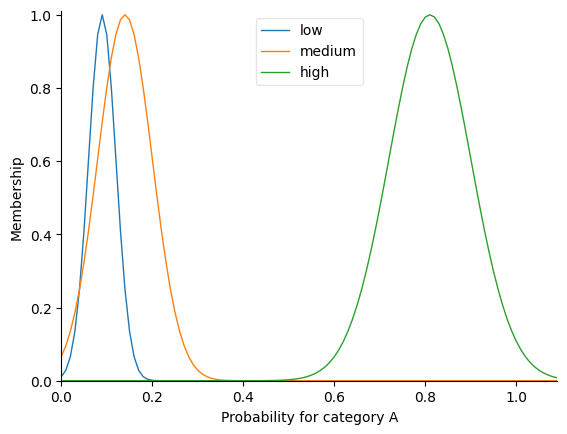

In [90]:
prob_classe1['low'] = fuzz.gaussmf(prob_classe1.universe, 0.09, 0.03)
prob_classe1['medium'] = fuzz.gaussmf(prob_classe1.universe, 0.14, 0.06)
prob_classe1['high'] = fuzz.gaussmf(prob_classe1.universe, 0.81, 0.09)

prob_classe1.view()

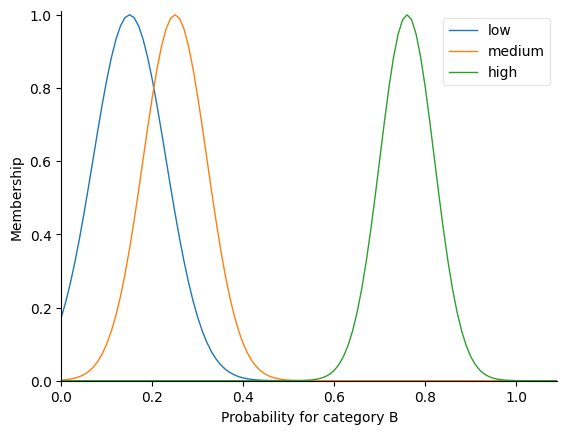

In [92]:
prob_classe2['low'] = fuzz.gaussmf(prob_classe2.universe, 0.15, 0.08)
prob_classe2['medium'] = fuzz.gaussmf(prob_classe2.universe, 0.25, 0.07)
prob_classe2['high'] = fuzz.gaussmf(prob_classe2.universe, 0.76, 0.06)
prob_classe2.view()

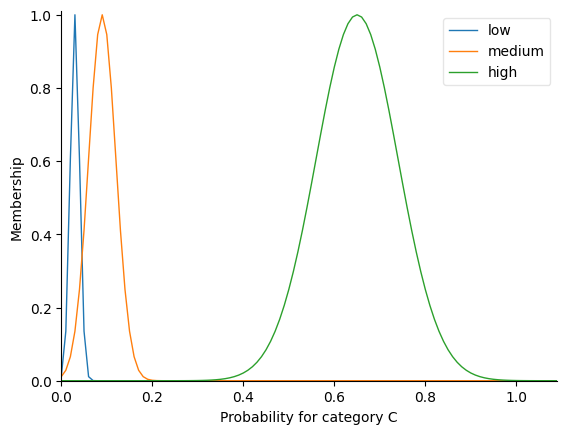

In [91]:
prob_classe3['low'] =  fuzz.gaussmf(prob_classe3.universe, 0.03, 0.01)
prob_classe3['medium'] = fuzz.gaussmf(prob_classe3.universe, 0.09, 0.03)
prob_classe3['high'] = fuzz.gaussmf(prob_classe3.universe, 0.65, 0.09)
prob_classe3.view()

In [ ]:
# prob_classe3 = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'prob_classe3')
classe_final = ctrl.Consequent(np.arange(1, 4, 1), 'Final classification')

classe_final['category A'] = fuzz.trimf(classe_final.universe, [0.5, 1, 1.8]) 
classe_final['category B'] = fuzz.trimf(classe_final.universe, [1.4, 2, 2.5]) 
classe_final['category C'] = fuzz.trimf(classe_final.universe, [2.2, 3, 3.5])

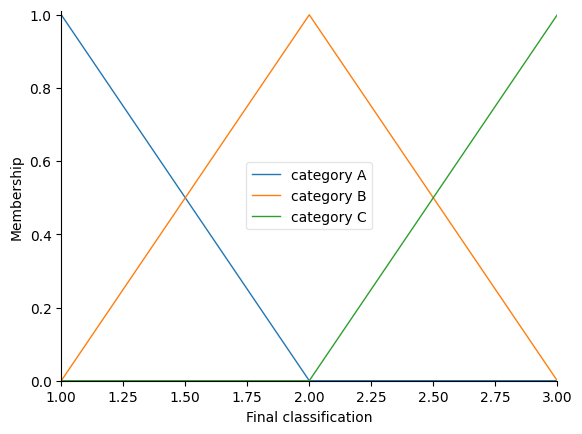

In [58]:
classe_final.view()

In [17]:
K = 5

In [18]:
classe_final = ctrl.Consequent(np.arange(1, K, 0.01), 'Final classification')

In [19]:
for k in range(1, K+1):
    name = f'Category_{k}'
    alpha = k - 1
    beta = k
    gamma = k + 1
    classe_final[name] = fuzz.trimf(classe_final.universe, [alpha, beta, gamma])

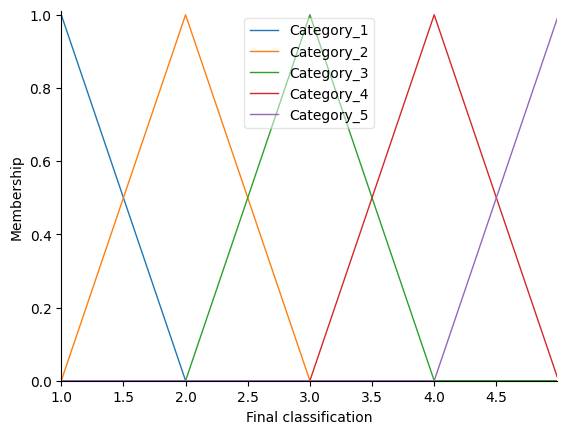

In [20]:
classe_final.view()